# Generative Basic Assignment (2024/03/13)
#### Questions(1,2) are below
#### Contact -> toa2413@naver.com / 송인혁(투빅스20기)

In [1]:
import datetime
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="../data", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root="../data", train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=4)

### Q1. Encoder/Decoder Implementation
    Show me your visualizations(MNIST images) using a VAE model made up of your own 'Encoder2/Decoder2'
    I can see your visualizations at the last part of this code file (Assignment 1 ; Visualization)
    
***You can refer to the examples right under this markdown, please make your own Encoder (Class name; Encoder2/Decoder2)***

In [23]:
# You can freely choose one of architectures you want that looks promising
class Encoder(nn.Module):    
    def __init__(self, input_dim, hidden_dim, hidden_dim2, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim2)
        self.mean = nn.Linear(hidden_dim2, latent_dim)
        self.var = nn.Linear (hidden_dim2, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)        
        self.training = True
        
    def forward(self, x):
        h_ = self.LeakyReLU(self.input1(x))
        h_ = self.LeakyReLU(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)                         
        return mean, log_var

In [46]:
class Encoder2(nn.Module):
    def __init__(self,input_dim, hidden_dim, hidden_dim2, latent_dim) :
        super().__init__()
        
        self.fc1 = nn.Sequential(
            nn.Linear(x_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        
        self.mu = nn.Linear(hidden_dim2, latent_dim)
        self.logvar = nn.Linear(hidden_dim2, latent_dim)
            
    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        
        mu = self.mu(x)
        logvar = self.logvar(x)
        
        return mu, logvar

In [25]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, hidden_dim2, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim2)
        self.hidden2 = nn.Linear(hidden_dim2, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.hidden1(x))
        h = self.LeakyReLU(self.hidden2(h))        
        x_hat = torch.sigmoid(self.output(h))
        return x_hat

In [58]:
class Decoder2(nn.Module):
    def __init__(self,latent_dim,hidden_dim,hidden_dim2, output_dim):
        super().__init__()
        
        self.fc1 = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_dim2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self,x) :
        x = self.fc1(x)
        x = self.fc2(x)
        p = torch.sigmoid(self.fc3(x)) # 베르누이 분포로 가정 -> 시그모이드
        
        return p

In [59]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    # Think about why you need reparameterization trick (Hint; backpropagation)
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)                
        z = mean + var*epsilon                          
        return z
                        
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.Decoder(z)        
        return x_hat, mean, log_var

In [64]:
# Any modifications are allowed depending on your own Encoder2/Decoder2
# -----------------------------------
x_dim  = 784
hidden_dim = 512
hidden_dim2 = 256
latent_dim = 20
epochs = 30
batch_size = 100
# -----------------------------------



# encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, hidden_dim2=hidden_dim2, latent_dim=latent_dim)
encoder = Encoder2(input_dim = x_dim, hidden_dim = hidden_dim,hidden_dim2 = hidden_dim2, latent_dim = latent_dim) 

# decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, hidden_dim2=hidden_dim2, output_dim = x_dim)
decoder = Decoder2(latent_dim = latent_dim ,hidden_dim = hidden_dim,hidden_dim2 = hidden_dim2, output_dim = x_dim)  

model = Model(Encoder=encoder, Decoder=decoder).to(device)

### Q2. (Optional Assignment)
    Refering to Beta-VAE(https://openreview.net/forum?id=Sy2fzU9gl), give any kind of manipulations on pre-made loss function, and visualize your samples.
    It would be nice to see whether the fidelity of sample data is improved or not! Also guess why.
***Warning)  you don't have to take all the contents of this paper! Look carefully at the Equation (4)***

In [65]:
# (Optional Assignment)
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # Think about how to calculate KLDivergence in closed form (Hint; assumptions for Gaussian), please refer to the following links
    # https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [66]:
def train(epoch, model, train_loader, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        BCE, KLD = loss_function(x, x_hat, mean, log_var)
        loss = BCE + KLD
        
        train_loss += loss.item()  
        loss.backward()
        optimizer.step()
          
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(x)))
            
    print("======> Epoch: {} Average loss: {:.4f}".format(
        epoch, train_loss / len(train_loader.dataset)))

In [67]:
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)        
            x_hat, mean, log_var = model(x)
            BCE, KLD = loss_function(x, x_hat, mean, log_var)
            loss = BCE + KLD

            test_loss += loss.item()

            if batch_idx == 0:
                n = min(x.size(0), 8)
                comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
                grid = torchvision.utils.make_grid(comparison.cpu())

In [68]:
# Trackning the process
# If you have difficulty on installing 'tqdm', modifications are allowed. Not necessary 
from tqdm.auto import tqdm

# Training an VAE model, and record losses
for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
    print("\n")


  0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	 Loss: 545.853008
Train Epoch: 0 [10000/60000 (17%)]	 Loss: 203.306367
Train Epoch: 0 [20000/60000 (33%)]	 Loss: 183.679531
Train Epoch: 0 [30000/60000 (50%)]	 Loss: 173.179492
Train Epoch: 0 [40000/60000 (67%)]	 Loss: 156.391768
Train Epoch: 0 [50000/60000 (83%)]	 Loss: 155.811943
======> Epoch: 0 Average loss: 179.9475


Train Epoch: 1 [0/60000 (0%)]	 Loss: 153.741680
Train Epoch: 1 [10000/60000 (17%)]	 Loss: 140.402061
Train Epoch: 1 [20000/60000 (33%)]	 Loss: 141.378115
Train Epoch: 1 [30000/60000 (50%)]	 Loss: 138.821426
Train Epoch: 1 [40000/60000 (67%)]	 Loss: 134.352812
Train Epoch: 1 [50000/60000 (83%)]	 Loss: 137.347461
======> Epoch: 1 Average loss: 141.6017


Train Epoch: 2 [0/60000 (0%)]	 Loss: 129.842305
Train Epoch: 2 [10000/60000 (17%)]	 Loss: 138.141934
Train Epoch: 2 [20000/60000 (33%)]	 Loss: 132.828242
Train Epoch: 2 [30000/60000 (50%)]	 Loss: 136.560479
Train Epoch: 2 [40000/60000 (67%)]	 Loss: 141.431973
Train Epoch: 2 [50000/60000 (8

======> Epoch: 22 Average loss: 119.7222


Train Epoch: 23 [0/60000 (0%)]	 Loss: 123.552695
Train Epoch: 23 [10000/60000 (17%)]	 Loss: 121.570664
Train Epoch: 23 [20000/60000 (33%)]	 Loss: 115.691777
Train Epoch: 23 [30000/60000 (50%)]	 Loss: 120.064248
Train Epoch: 23 [40000/60000 (67%)]	 Loss: 114.091875
Train Epoch: 23 [50000/60000 (83%)]	 Loss: 114.965615
======> Epoch: 23 Average loss: 119.5696


Train Epoch: 24 [0/60000 (0%)]	 Loss: 121.443789
Train Epoch: 24 [10000/60000 (17%)]	 Loss: 117.457451
Train Epoch: 24 [20000/60000 (33%)]	 Loss: 120.097656
Train Epoch: 24 [30000/60000 (50%)]	 Loss: 121.100547
Train Epoch: 24 [40000/60000 (67%)]	 Loss: 116.742041
Train Epoch: 24 [50000/60000 (83%)]	 Loss: 122.666758
======> Epoch: 24 Average loss: 119.4296


Train Epoch: 25 [0/60000 (0%)]	 Loss: 115.794297
Train Epoch: 25 [10000/60000 (17%)]	 Loss: 117.030771
Train Epoch: 25 [20000/60000 (33%)]	 Loss: 120.723418
Train Epoch: 25 [30000/60000 (50%)]	 Loss: 116.972998
Train Epoch: 25 [40000

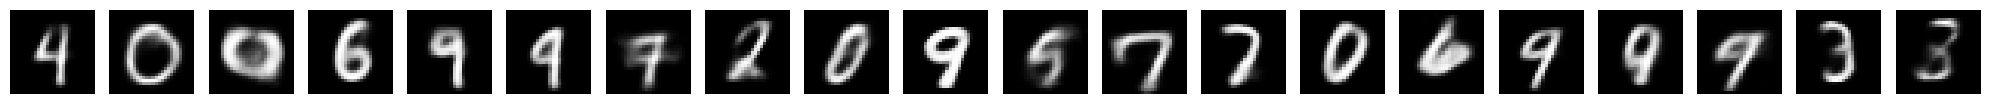

In [69]:
# After training decoder, begin visualize what comes after decoder given input z
def visualize(decoder,z):
    x_sample = decoder(z).view(20,28,28).detach().numpy()
    fig, axes = plt.subplots(nrows=1, ncols=20, figsize=(20, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(x_sample[i], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

z_sample = torch.randn(20,20)

# (Assignment 1 ; Visualization)
visualize(decoder,z_sample)


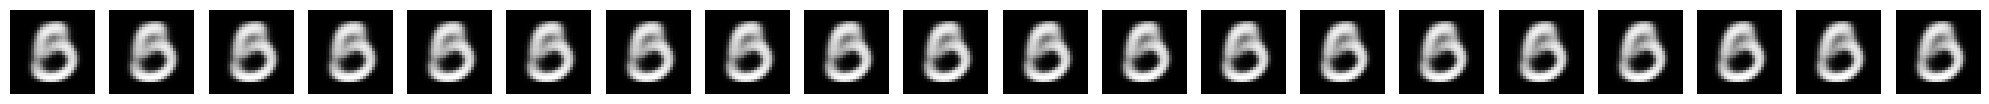

In [70]:
# Set seed numbers to take reproducibility
seed = 3
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
np.random.seed(seed)

# Random z
z = torch.randn(20)
# Make copies
z = z.repeat(20,1)

# Interpolation in latent space z 
for i in range(20):
    z[i, 0] += i * 0.5 - (20 - 1) * 0.5 / 2

# (Assignment 1 ; Visualization)
visualize(decoder,z)

## Answer(Q2; Optional) : Please write any codes or statements below this space
